In [2]:
import pandas as pd
import os
import numpy as np
import random

from ase.io import read
from ase.db import connect
from ase import io
from ase.visualize import view
from ase import Atoms
from ase.calculators.aims import Aims
from ase.build import molecule

from dscribe.descriptors import SOAP

from sklearn.model_selection import train_test_split
from sklearn.kernel_ridge import KernelRidge
from sklearn.metrics import mean_squared_error, r2_score


# Import structures

In [3]:
with open('gdb7-13/dsgdb7njp.xyz') as f:
    geometries = f.read()
geometries = geometries.split('\n\n')
len(geometries)

7211

In [4]:
val_set_index = np.random.choice(range(len(geometries[1:])),size=int(len(geometries)/3))

In [5]:
val_set_index

array([6501, 4539, 5966, ...,  507, 5930,  833])

In [6]:
small_molecules = []
targets = []
val_small_molecules = []
val_targets = []
for i, geometry in enumerate(geometries):
    if i not in val_set_index:
        with open(f'geometries/{i}.xyz','w') as f:
            f.write(geometry)
        small_molecules.append(io.read(f'geometries/{i}.xyz'))
        targets.append([float(val) for val in geometry.split('\n')[1].split(' ')])
        os.remove(f'geometries/{i}.xyz')
    else:
        with open(f'geometries/{i}.xyz','w') as f:
            f.write(geometry)
        val_small_molecules.append(io.read(f'geometries/{i}.xyz'))
        val_targets.append([float(val) for val in geometry.split('\n')[1].split(' ')])
        os.remove(f'geometries/{i}.xyz')        
  

In [7]:
len(small_molecules),len(val_small_molecules)

(5162, 2049)

In [8]:
len(targets),len(val_targets)

(5162, 2049)

In [9]:
# I. Identifier Unit       Description
# -- ---------- ---------- -----------
# 01 ae_pbe0    kcal/mol   Atomization energy (DFT/PBE0)
# 02 p_pbe0     Angstrom^3 Polarizability (DFT/PBE0)
# 03 p_scs      Angstrom^3 Polarizability (self-consistent screening)
# 04 homo_gw    eV         Highest occupied molecular orbital (GW)
# 05 homo_pbe0  eV         Highest occupied molecular orbital (DFT/PBE0)
# 06 homo_zindo eV         Highest occupied molecular orbital (ZINDO/s)
# 07 lumo_gw    eV         Lowest unoccupied molecular orbital (GW)
# 08 lumo_pbe0  eV         Lowest unoccupied molecular orbital (DFT/PBE0)
# 09 lumo_zindo eV         Lowest unoccupied molecular orbital (ZINDO/s)
# 10 ip_zindo   eV         Ionization potential (ZINDO/s)
# 11 ea_zindo   eV         Electron affinity (ZINDO/s)
# 12 e1_zindo   eV         First excitation energy (ZINDO)
# 13 emax_zindo eV         Maximal absorption intensity (ZINDO)
# 14 imax_zindo arbitrary  Excitation energy at maximal absorption (ZINDO)

In [10]:
targets_df =pd.DataFrame(targets, columns=['ae_pbe0', 'p_pbe0', 'p_scs', 'homo_gw', 'homo_pbe0', 'homo_zindo', 'lumo_gw', 'lumo_pbe0', 'lumo_zindo', 'ip_zindo', 'ea_zindo', 'e1_zindo', 'emax_zindo', 'imax_zindo'])

In [11]:
targets_df

,ae_pbe0,p_pbe0,p_scs,homo_gw,homo_pbe0,homo_zindo,lumo_gw,lumo_pbe0,lumo_zindo,ip_zindo,ea_zindo,e1_zindo,emax_zindo,imax_zindo
0,-420.933734,2.534576,2.43222,-14.1341,-10.9488,-16.013,1.0870,0.1323,4.162,15.72523,-3.98613,36.768073,39.694626,0.621841
1,-718.419179,4.332028,4.44500,-12.5472,-9.5577,-13.549,1.1186,0.1452,3.684,13.41121,-3.49181,11.717433,22.622486,0.628328
2,-570.024856,4.173282,3.92308,-10.4383,-7.8768,-10.160,1.9456,-0.0620,1.231,9.75211,-0.82042,7.137266,22.940671,0.709060
3,-628.255705,4.457560,4.66876,-12.0735,-9.4054,-12.005,0.7005,-0.2887,1.418,11.60198,-1.11074,5.392226,12.513882,0.849751
4,-881.905874,5.804944,5.91386,-8.8174,-6.4807,-10.093,1.0623,0.0510,3.833,9.45197,-3.69332,8.264870,17.734201,0.400285
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
5157,-1109.600987,10.069128,11.29757,-10.7005,-8.4251,-10.697,0.9389,-0.5539,-0.494,10.42614,0.89007,4.362956,10.914760,0.117003
5158,-1343.513850,12.755189,13.29895,-7.8786,-6.0811,-8.721,0.9163,-0.4509,-0.004,7.81747,0.76079,3.271309,10.797284,0.721207
5159,-1330.148845,12.767596,13.18706,-7.9069,-6.1207,-8.788,0.7085,-0.8678,-0.117,7.85228,0.89004,3.117566,10.801065,0.877879
5160,-1355.485597,13.711397,13.44517,-7.8981,-6.1532,-8.657,0.6403,-0.9280,-0.191,7.71657,0.93841,3.249053,10.697140,0.609902


In [12]:
species = set()
for mol in small_molecules:
    species.update(mol.get_chemical_symbols())
species

{'C', 'Cl', 'H', 'N', 'O', 'S'}

In [13]:
soap = SOAP(
    species=species,
    periodic=False,
    rcut=5,
    nmax=5,
    lmax=5,
    average='outer',
    sparse=False,
)

In [14]:
feature_vectors = soap.create(small_molecules)

In [90]:
chemical_formulas = []
for mol in small_molecules:
    chemical_formulas.append(mol.get_chemical_formula())
chemical_formulas

['CH4',
 'C2H6',
 'C2H4',
 'C2H3N',
 'C2H7N',
 'C2H4O',
 'C2H4O',
 'C4H10',
 'C4H6',
 'C4H4',
 'C4H2',
 'C4H8',
 'C4H8',
 'C4H6',
 'C4H8',
 'C3H7N',
 'C3H3N',
 'C3HN',
 'C3H9N',
 'C3H5N',
 'C3H9N',
 'C3H7N',
 'C3H9N',
 'C3H7N',
 'C3H5N',
 'C3H6O',
 'C3H6O',
 'C3H8O',
 'C3H6O',
 'C3H6O',
 'C3H8O',
 'C3H6O',
 'C3H2O',
 'C3H6O',
 'C3H4O',
 'C2H5NO',
 'C2H5NO',
 'C2H5NO',
 'C2H7NO',
 'C5H10',
 'C5H10',
 'C5H12',
 'C5H12',
 'C5H6',
 'C5H8',
 'C5H8',
 'C5H10',
 'C5H8',
 'C5H6',
 'C5H10',
 'C5H8',
 'C5H6',
 'C5H4',
 'C5H10',
 'C5H8',
 'C5H10',
 'C5H8',
 'C4H9N',
 'C4H5N',
 'C4H7N',
 'C4H9N',
 'C4H9N',
 'C4H9N',
 'C4H9N',
 'C4H7N',
 'C4H5N',
 'C4H11N',
 'C4H3N',
 'C4H9N',
 'C4H5N',
 'C4H5N',
 'C4H11N',
 'C4H7N',
 'C4H7N',
 'C4H7N',
 'C4H11N',
 'C4H9N',
 'C4H11N',
 'C4H9N',
 'C4H7N',
 'C4H11N',
 'C4H9N',
 'C4H9N',
 'C4H9N',
 'C4H7N',
 'C3H6N2',
 'C4H9N',
 'C4H9N',
 'C4H5N',
 'C3H4N2',
 'C4H7N',
 'C3H4N2',
 'C4H6O',
 'C4H4O',
 'C4H8O',
 'C4H6O',
 'C4H8O',
 'C4H8O',
 'C4H8O',
 'C4H8O',
 'C4H8O',


In [15]:
df = pd.DataFrame(feature_vectors)

In [16]:
df

,0,1,2,3,4,5,6,7,8,9,...,2780,2781,2782,2783,2784,2785,2786,2787,2788,2789
0,0.027089,0.219349,0.685568,1.525990,2.526201,1.776239,5.548944,12.355682,20.477083,17.395169,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
1,0.021571,0.152419,0.494116,0.957821,2.885999,1.087559,3.545340,7.018930,20.634221,11.593550,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
2,0.018506,0.130041,0.394745,0.660638,1.746955,0.920858,2.816295,4.847760,12.602659,8.675296,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
3,0.016177,0.125785,0.382787,0.758597,1.200883,1.017210,3.032972,6.302599,9.240071,9.208374,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
4,0.029245,0.150483,0.589414,0.777112,3.203749,0.792353,3.085801,4.247002,17.278751,12.144739,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
5157,0.016962,0.085502,0.315316,0.293245,0.900410,0.484138,1.638974,1.773217,3.790771,5.959481,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
5158,0.022970,0.086154,0.384266,0.156350,1.823232,0.391506,1.505384,0.990704,6.480588,6.578383,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
5159,0.022179,0.089375,0.389258,0.276373,1.851014,0.455697,1.666327,1.710582,6.806009,7.033211,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
5160,0.023941,0.088550,0.411241,0.291277,1.856765,0.400639,1.567889,1.450443,6.054276,7.193442,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0


<AxesSubplot:>

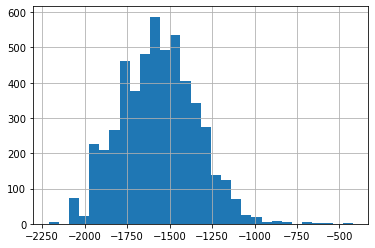

In [17]:
targets_df['ae_pbe0'].hist(bins=30)

In [18]:
targets_df['ae_pbe0'].mean() # units eV

-1564.6527159654281

In [19]:
targets_df['ae_pbe0'].std() # units eV

223.34735649816966

In [20]:
train_pred_df, test_pred_df, train_target_df, test_target_df = train_test_split(df, targets_df['ae_pbe0'], test_size=0.33, random_state=0)

In [21]:
krr = KernelRidge(alpha=1.0)
krr.fit(train_pred_df,train_target_df)

KernelRidge(alpha=1.0)

In [22]:
predictions = krr.predict(train_pred_df)
rmse = mean_squared_error(train_target_df, predictions, squared=False)
print('rmse: %.3f' % (rmse*0.043))
print('R2 score is: %.3f' % r2_score(train_target_df, predictions))

rmse: 0.426
R2 score is: 0.998


In [23]:
test_pred_df

,0,1,2,3,4,5,6,7,8,9,...,2780,2781,2782,2783,2784,2785,2786,2787,2788,2789
3244,0.028903,0.102310,0.497273,0.322238,2.652965,0.410175,1.800266,1.391985,8.627290,8.712977,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
4588,0.024963,0.104723,0.451437,0.383493,1.390344,0.507904,1.955627,1.967049,4.771192,8.274862,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
1999,0.032129,0.124064,0.581272,0.561110,2.719125,0.644200,2.446294,3.300563,9.915349,10.909682,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
2624,0.062522,0.129584,1.013966,0.306327,5.158949,0.339216,2.158731,1.009461,9.002167,16.618654,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
2992,0.056873,0.146315,0.970323,0.537162,4.208786,0.498673,2.623516,2.172897,8.154903,16.783670,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
4891,0.026231,0.099815,0.449669,0.280075,1.677631,0.430858,1.734241,1.251556,5.273986,7.785758,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
2962,0.048204,0.123182,0.792796,0.341483,3.679861,0.407808,2.082144,1.245669,7.338063,13.187851,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
3304,0.037356,0.114559,0.634906,0.334068,3.332603,0.461068,2.065686,1.674977,9.175278,11.032454,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
4362,0.031140,0.106882,0.531438,0.322283,2.239675,0.464463,1.882591,1.580864,6.258816,9.180293,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0


In [24]:
predictions = krr.predict(test_pred_df)
rmse = mean_squared_error(test_target_df, predictions, squared=False)
print('rmse: %.3f' % (rmse*0.043))
print('R2 score is: %.3f' % r2_score(test_target_df, predictions))

rmse: 0.438
R2 score is: 0.998


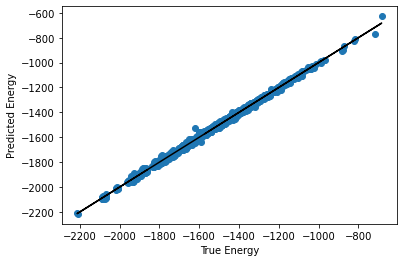

In [25]:
import matplotlib.pyplot as plt
plt.plot(test_target_df, predictions, 'o')
plt.xlabel('True Energy')
plt.ylabel('Predicted Energy')
# We also plot a diagonal line to show where the prediction should end up.
plt.plot(list(test_target_df),list(test_target_df),'k-') # identity line
plt.show()

In [26]:
# Linear Regression
from sklearn.linear_model import LinearRegression
ln_model = LinearRegression()
ln_model.fit(train_pred_df,train_target_df)
ln_predictions = ln_model.predict(train_pred_df)
rmse = mean_squared_error(train_target_df, ln_predictions, squared=False)
print('rmse: %.3f' % (rmse))
print('R2 score is: %.3f' % r2_score(train_target_df, ln_predictions))


rmse: 2.059
R2 score is: 1.000


rmse: 10.195
R2 score is: 0.998


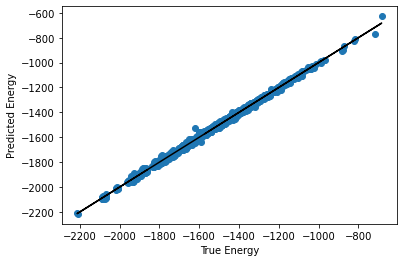

In [27]:
ln_predictions = krr.predict(test_pred_df)
rmse = mean_squared_error(test_target_df, ln_predictions, squared=False)
print('rmse: %.3f' % (rmse))
print('R2 score is: %.3f' % r2_score(test_target_df, ln_predictions))
import matplotlib.pyplot as plt
plt.plot(test_target_df, ln_predictions, 'o')
plt.xlabel('True Energy')
plt.ylabel('Predicted Energy')
# We also plot a diagonal line to show where the prediction should end up.
plt.plot(list(test_target_df),list(test_target_df),'k-') # identity line
plt.show()

In [28]:
train_pred_df.loc[:,:]

,0,1,2,3,4,5,6,7,8,9,...,2780,2781,2782,2783,2784,2785,2786,2787,2788,2789
4041,0.046690,0.128371,0.783714,0.359151,4.029559,0.459569,2.270079,1.633813,9.202390,13.430091,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
3402,0.047583,0.119040,0.780453,0.285317,4.351118,0.387973,2.026924,1.213656,9.038971,13.005383,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
3471,0.038807,0.118398,0.655886,0.190840,3.180288,0.487015,2.142422,1.383698,8.809933,11.327457,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
2961,0.036111,0.135154,0.660005,0.664633,2.412552,0.679616,2.653800,3.648352,7.185383,12.364128,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
1530,0.030542,0.111670,0.542647,0.407722,2.362000,0.503161,2.090182,2.058947,7.925044,9.853993,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
4931,0.028155,0.094978,0.471601,0.203069,2.267998,0.401060,1.649162,1.065467,7.320313,8.050711,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
3264,0.043788,0.116680,0.719282,0.244724,3.345476,0.352880,1.923233,0.652755,7.246342,11.890395,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
1653,0.018084,0.091648,0.356006,0.419800,1.100883,0.602797,1.990631,3.288840,5.290468,7.320699,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
2607,0.019539,0.106214,0.385535,0.529735,1.323542,0.666776,2.186996,3.444993,6.165541,7.801111,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0


rmse: 0.485
R2 score is: 1.000
rmse: 6.847
R2 score is: 0.999


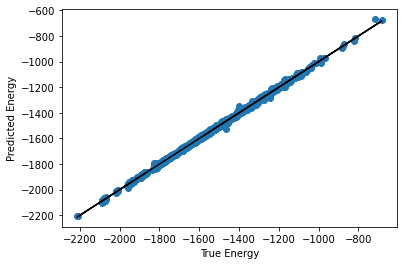

rmse: 0.751
R2 score is: 1.000
rmse: 6.751
R2 score is: 0.999


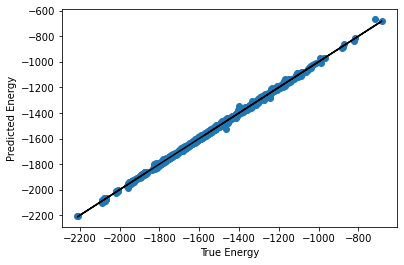

rmse: 0.944
R2 score is: 1.000
rmse: 6.699
R2 score is: 0.999


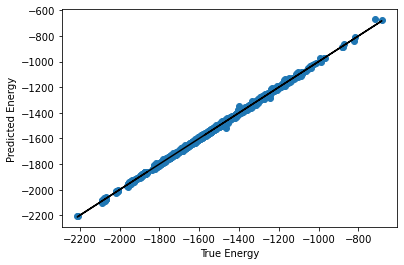

In [29]:
for alpha in [0.01,0.02,0.03]:
    ln_model = KernelRidge(kernel='poly', alpha = alpha, degree=3)
    ln_model.fit(train_pred_df,train_target_df)
    ln_predictions = ln_model.predict(train_pred_df)
    rmse = mean_squared_error(train_target_df, ln_predictions, squared=False)
    print('rmse: %.3f' % (rmse))
    print('R2 score is: %.3f' % r2_score(train_target_df, ln_predictions))
    ln_predictions = ln_model.predict(test_pred_df)
    rmse = mean_squared_error(test_target_df, ln_predictions, squared=False)
    print('rmse: %.3f' % (rmse))
    print('R2 score is: %.3f' % r2_score(test_target_df, ln_predictions))
    import matplotlib.pyplot as plt
    plt.plot(test_target_df, ln_predictions, 'o')
    plt.xlabel('True Energy')
    plt.ylabel('Predicted Energy')
    # We also plot a diagonal line to show where the prediction should end up.
    plt.plot(list(test_target_df),list(test_target_df),'k-') # identity line
    plt.show()

In [30]:
from sklearn.model_selection import GridSearchCV
parameters={
    'alpha': np.linspace(0.0004,0.0006,5),
    'degree':[2]
}
kernel_ridge_tuned = GridSearchCV(
    KernelRidge(kernel='poly'),
    param_grid=parameters,
    scoring='neg_root_mean_squared_error',
    verbose=1
)
kernel_ridge_tuned.fit(train_pred_df,train_target_df)

Fitting 5 folds for each of 5 candidates, totalling 25 fits


GridSearchCV(estimator=KernelRidge(kernel='poly'),
             param_grid={'alpha': array([0.0004 , 0.00045, 0.0005 , 0.00055, 0.0006 ]),
                         'degree': [2]},
             scoring='neg_root_mean_squared_error', verbose=1)

In [31]:
kernel_ridge_tuned.best_params_

{'alpha': 0.0006, 'degree': 2}

rmse: 4.87
R2 score is: 0.9995


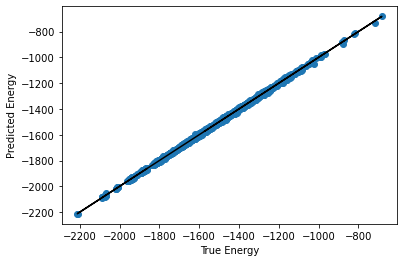

In [32]:
ln_predictions = kernel_ridge_tuned.predict(test_pred_df)
rmse = mean_squared_error(test_target_df, ln_predictions, squared=False)
print('rmse: %.2f' % (rmse))
print('R2 score is: %.4f' % r2_score(test_target_df, ln_predictions))
import matplotlib.pyplot as plt
plt.plot(test_target_df, ln_predictions, 'o')
plt.xlabel('True Energy')
plt.ylabel('Predicted Energy')
# We also plot a diagonal line to show where the prediction should end up.
plt.plot(list(test_target_df),list(test_target_df),'k-') # identity line
plt.show()

In [33]:
import sklearn
sklearn.metrics.SCORERS.keys()

dict_keys(['explained_variance', 'r2', 'max_error', 'neg_median_absolute_error', 'neg_mean_absolute_error', 'neg_mean_absolute_percentage_error', 'neg_mean_squared_error', 'neg_mean_squared_log_error', 'neg_root_mean_squared_error', 'neg_mean_poisson_deviance', 'neg_mean_gamma_deviance', 'accuracy', 'top_k_accuracy', 'roc_auc', 'roc_auc_ovr', 'roc_auc_ovo', 'roc_auc_ovr_weighted', 'roc_auc_ovo_weighted', 'balanced_accuracy', 'average_precision', 'neg_log_loss', 'neg_brier_score', 'adjusted_rand_score', 'rand_score', 'homogeneity_score', 'completeness_score', 'v_measure_score', 'mutual_info_score', 'adjusted_mutual_info_score', 'normalized_mutual_info_score', 'fowlkes_mallows_score', 'precision', 'precision_macro', 'precision_micro', 'precision_samples', 'precision_weighted', 'recall', 'recall_macro', 'recall_micro', 'recall_samples', 'recall_weighted', 'f1', 'f1_macro', 'f1_micro', 'f1_samples', 'f1_weighted', 'jaccard', 'jaccard_macro', 'jaccard_micro', 'jaccard_samples', 'jaccard_wei

In [34]:
index, random_molecule = random.choice(list(enumerate(val_small_molecules)))

In [35]:
val_targets[index][0]

-1026.638652428286

In [36]:
random_molecule.get_number_of_atoms()

/Users/maria/opt/anaconda3/lib/python3.9/site-packages/ase/atoms.py:967: VisibleDeprecationWarning: Use get_global_number_of_atoms() instead
  warnings.warn('Use get_global_number_of_atoms() instead',


9

In [37]:
random_molecule.translate(-random_molecule.get_center_of_mass())

In [38]:
view(random_molecule, viewer='x3d')

In [39]:
features = pd.DataFrame(soap.create(random_molecule)).transpose()

In [40]:
features

,0,1,2,3,4,5,6,7,8,9,...,2780,2781,2782,2783,2784,2785,2786,2787,2788,2789
0,0.008702,0.06207,0.187003,0.332383,0.72373,0.514276,1.421022,2.886526,5.293887,4.202493,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0


In [41]:
prediction = krr.predict(features)
prediction

array([-1049.01205429])

In [42]:
val_targets[index][0]

-1026.638652428286

In [43]:
methane = small_molecules[0] # molecule('CH4')

In [44]:
os.system('say "Your calculation is starting"')

0

In [45]:
e_atoms = []
for i,atom in enumerate(methane):
    atom = Atoms(atom.symbol)
    atom.calc = Aims(
        xc='pbe0',
        species_dir='/Users/maria/FHIaims/species_defaults/defaults_2010/tight',
        tier=2,
        sc_accuracy_rho=1E-6,
        sc_accuracy_eev=1E-6,
        sc_accuracy_etot=1E-6,
        aims_command='mpirun /Users/maria/FHIaims/build/aims.220309.scalapack.mpi.x',
        outfilename='aims.out',
        spin='collinear',
        default_initial_moment='hund',
    )
    e_atoms.append(atom.get_potential_energy())


In [46]:
methane.calc = Aims(
        xc='pbe0',
        species_dir='/Users/maria/FHIaims/species_defaults/defaults_2010/tight',
        tier=2,
        sc_accuracy_rho=1E-6,
        sc_accuracy_eev=1E-6,
        sc_accuracy_etot=1E-6,
        aims_command='mpirun /Users/maria/FHIaims/build/aims.220309.scalapack.mpi.x',
        outfilename='aims.out',
        spin='collinear',
        default_initial_moment=0.001,
    )
total_energy = methane.get_potential_energy()

In [47]:
os.system(f'say "your calculation has finished."')

0

In [48]:
(total_energy - sum(e_atoms))/0.043

-448.80446641564794

In [49]:
small_molecules[0]

Atoms(symbols='CH4', pbc=False, calculator=Aims(...))

In [50]:
targets[0][0]*0.043  # Units eV

-18.100150575110234

In [51]:
features = pd.DataFrame(soap.create(methane)).transpose()
features

,0,1,2,3,4,5,6,7,8,9,...,2780,2781,2782,2783,2784,2785,2786,2787,2788,2789
0,0.027089,0.219349,0.685568,1.52599,2.526201,1.776239,5.548944,12.355682,20.477083,17.395169,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0


In [52]:
prediction = krr.predict(features)
prediction

array([-469.04387273])

In [53]:
targets[0][0]

-420.9337343048892

In [ ]:
import time

In [ ]:
validation_molecules = []
for i, molecule in list(enumerate(val_small_molecules)):
    validation_molecules.append((i,molecule.get_chemical_formula()))
validation_molecules

[(0, 'C2H6'),
 (1, 'C2H4'),
 (2, 'C3H8'),
 (3, 'C2H5N'),
 (4, 'C2H7N'),
 (5, 'C2H3N'),
 (6, 'C2H4O'),
 (7, 'C2H4O'),
 (8, 'C4H6'),
 (9, 'C4H6'),
 (10, 'C3H7N'),
 (11, 'C3H9N'),
 (12, 'C3H3N'),
 (13, 'C3H9N'),
 (14, 'C3H5N'),
 (15, 'C3H9N'),
 (16, 'C3H7N'),
 (17, 'C3H7N'),
 (18, 'C3H5N'),
 (19, 'C3H8O'),
 (20, 'C3H6O'),
 (21, 'C3H6O'),
 (22, 'C3H6O'),
 (23, 'C3H4O'),
 (24, 'C2H5NO'),
 (25, 'C2H5NO'),
 (26, 'C2H5NO'),
 (27, 'C5H10'),
 (28, 'C5H10'),
 (29, 'C5H10'),
 (30, 'C5H12'),
 (31, 'C5H8'),
 (32, 'C5H6'),
 (33, 'C5H10'),
 (34, 'C5H8'),
 (35, 'C5H8'),
 (36, 'C5H6'),
 (37, 'C5H4'),
 (38, 'C5H10'),
 (39, 'C5H10'),
 (40, 'C5H8'),
 (41, 'C4H5N'),
 (42, 'C4H7N'),
 (43, 'C4H9N'),
 (44, 'C4H9N'),
 (45, 'C4H9N'),
 (46, 'C4H7N'),
 (47, 'C4H5N'),
 (48, 'C4H11N'),
 (49, 'C4H11N'),
 (50, 'C4H9N'),
 (51, 'C4H9N'),
 (52, 'C4H9N'),
 (53, 'C4H11N'),
 (54, 'C4H9N'),
 (55, 'C4H7N'),
 (56, 'C4H8O'),
 (57, 'C4H8O'),
 (58, 'C4H8O'),
 (59, 'C4H4O'),
 (60, 'C4H10O'),
 (61, 'C4H6O'),
 (62, 'C4H10O'),
 (63, 

In [ ]:
# polarizability

In [57]:
train_pred_df, test_pred_df, train_target_df, test_target_df = train_test_split(df, targets_df['p_pbe0'], test_size=0.33, random_state=0)

In [58]:
from sklearn.model_selection import GridSearchCV
parameters={
    'alpha': np.linspace(0.0001,2,5),
    'degree':[1,2,3]
}
kernel_ridge_tuned = GridSearchCV(
    KernelRidge(kernel='poly'),
    param_grid=parameters,
    scoring='neg_root_mean_squared_error',
    verbose=1
)
kernel_ridge_tuned.fit(train_pred_df,train_target_df)

Fitting 5 folds for each of 15 candidates, totalling 75 fits


GridSearchCV(estimator=KernelRidge(kernel='poly'),
             param_grid={'alpha': array([1.000000e-04, 5.000750e-01, 1.000050e+00, 1.500025e+00,
       2.000000e+00]),
                         'degree': [1, 2, 3]},
             scoring='neg_root_mean_squared_error', verbose=1)

In [59]:
kernel_ridge_tuned.best_params_

{'alpha': 0.0001, 'degree': 2}

In [62]:
parameters={
    'alpha': np.linspace(0.0009,5),
    'degree':[2]
}
kernel_ridge_tuned = GridSearchCV(
    KernelRidge(kernel='poly'),
    param_grid=parameters,
    scoring='neg_root_mean_squared_error',
    verbose=1
)
kernel_ridge_tuned.fit(train_pred_df,train_target_df)
kernel_ridge_tuned.best_params_

Fitting 5 folds for each of 5 candidates, totalling 25 fits


{'alpha': 0.0009, 'degree': 2}

rmse: 0.13
R2 score is: 0.9906


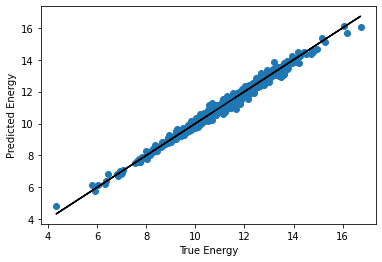

In [61]:
ln_predictions = kernel_ridge_tuned.predict(test_pred_df)
rmse = mean_squared_error(test_target_df, ln_predictions, squared=False)
print('rmse: %.2f' % (rmse))
print('R2 score is: %.4f' % r2_score(test_target_df, ln_predictions))
import matplotlib.pyplot as plt
plt.plot(test_target_df, ln_predictions, 'o')
plt.xlabel('True')
plt.ylabel('Predicted')
# We also plot a diagonal line to show where the prediction should end up.
plt.plot(list(test_target_df),list(test_target_df),'k-') # identity line
plt.show()

In [63]:
parameters={
    'alpha': np.linspace(0.0009,5,5),
    'gamma': np.linspace(0.0009,5,5),
}
kernel_ridge_tuned = GridSearchCV(
    KernelRidge(kernel='rbf'),
    param_grid=parameters,
    scoring='neg_root_mean_squared_error',
    verbose=1
)
kernel_ridge_tuned.fit(train_pred_df,train_target_df)
kernel_ridge_tuned.best_params_

Fitting 5 folds for each of 25 candidates, totalling 125 fits


{'alpha': 0.0009, 'gamma': 0.0009}

In [65]:
parameters={
    'alpha': np.linspace(0.00009,0.1,5),
    'gamma': np.linspace(0.00009,0.1,5),
}
kernel_ridge_tuned = GridSearchCV(
    KernelRidge(kernel='rbf'),
    param_grid=parameters,
    scoring='neg_root_mean_squared_error',
    verbose=2
)
kernel_ridge_tuned.fit(train_pred_df,train_target_df)
kernel_ridge_tuned.best_params_

Fitting 5 folds for each of 25 candidates, totalling 125 fits
[CV] END ...........................alpha=9e-05, gamma=9e-05; total time=   1.2s
[CV] END ...........................alpha=9e-05, gamma=9e-05; total time=   1.2s
[CV] END ...........................alpha=9e-05, gamma=9e-05; total time=   1.2s
[CV] END ...........................alpha=9e-05, gamma=9e-05; total time=   1.1s
[CV] END ...........................alpha=9e-05, gamma=9e-05; total time=   1.0s
[CV] END .......................alpha=9e-05, gamma=0.0250675; total time=   4.7s
[CV] END .......................alpha=9e-05, gamma=0.0250675; total time=   6.3s
[CV] END .......................alpha=9e-05, gamma=0.0250675; total time=   5.2s
[CV] END .......................alpha=9e-05, gamma=0.0250675; total time=   4.9s
[CV] END .......................alpha=9e-05, gamma=0.0250675; total time=   5.5s
[CV] END ........................alpha=9e-05, gamma=0.050045; total time=   2.3s
[CV] END ........................alpha=9e-05, g

{'alpha': 9e-05, 'gamma': 9e-05}

In [74]:
parameters={
    'alpha': np.linspace(1e-11,1e-10,3),
    'gamma': np.linspace(5e-9,5e-8,4),
}
kernel_ridge_tuned = GridSearchCV(
    KernelRidge(kernel='rbf'),
    param_grid=parameters,
    scoring='neg_root_mean_squared_error',
    verbose=2
)
kernel_ridge_tuned.fit(train_pred_df,train_target_df)
kernel_ridge_tuned.best_params_

Fitting 5 folds for each of 12 candidates, totalling 60 fits
[CV] END ...........................alpha=1e-11, gamma=5e-09; total time=   2.2s
[CV] END ...........................alpha=1e-11, gamma=5e-09; total time=   1.2s
[CV] END ...........................alpha=1e-11, gamma=5e-09; total time=   1.2s
[CV] END ...........................alpha=1e-11, gamma=5e-09; total time=   1.5s
[CV] END ...........................alpha=1e-11, gamma=5e-09; total time=   1.6s
[CV] END ...........................alpha=1e-11, gamma=2e-08; total time=   1.6s
[CV] END ...........................alpha=1e-11, gamma=2e-08; total time=   1.2s
[CV] END ...........................alpha=1e-11, gamma=2e-08; total time=   1.5s
[CV] END ...........................alpha=1e-11, gamma=2e-08; total time=   1.3s
[CV] END ...........................alpha=1e-11, gamma=2e-08; total time=   1.5s
[CV] END ..........alpha=1e-11, gamma=3.4999999999999996e-08; total time=   1.2s
[CV] END ..........alpha=1e-11, gamma=3.49999999

{'alpha': 1e-10, 'gamma': 3.4999999999999996e-08}

rmse: 0.12
R2 score is: 0.9919


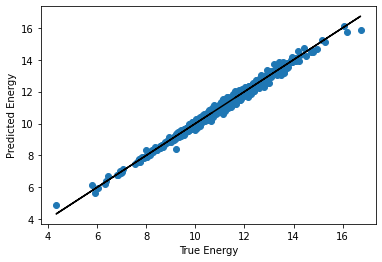

In [75]:
ln_predictions = kernel_ridge_tuned.predict(test_pred_df)
rmse = mean_squared_error(test_target_df, ln_predictions, squared=False)
print('rmse: %.2f' % (rmse))
print('R2 score is: %.4f' % r2_score(test_target_df, ln_predictions))
import matplotlib.pyplot as plt
plt.plot(test_target_df, ln_predictions, 'o')
plt.xlabel('True')
plt.ylabel('Predicted')
# We also plot a diagonal line to show where the prediction should end up.
plt.plot(list(test_target_df),list(test_target_df),'k-') # identity line
plt.show()

rmse: 0.187
R2 score is: 0.981
rmse: 0.197
R2 score is: 0.977


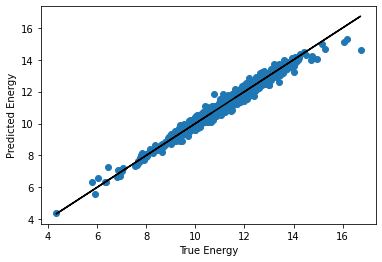

In [67]:
ln_model = KernelRidge()
ln_model.fit(train_pred_df,train_target_df)
ln_predictions = ln_model.predict(train_pred_df)
rmse = mean_squared_error(train_target_df, ln_predictions, squared=False)
print('rmse: %.3f' % (rmse))
print('R2 score is: %.3f' % r2_score(train_target_df, ln_predictions))
ln_predictions = ln_model.predict(test_pred_df)
rmse = mean_squared_error(test_target_df, ln_predictions, squared=False)
print('rmse: %.3f' % (rmse))
print('R2 score is: %.3f' % r2_score(test_target_df, ln_predictions))
import matplotlib.pyplot as plt
plt.plot(test_target_df, ln_predictions, 'o')
plt.xlabel('True')
plt.ylabel('Predicted')
# We also plot a diagonal line to show where the prediction should end up.
plt.plot(list(test_target_df),list(test_target_df),'k-') # identity line
plt.show()

rmse: 0.184
R2 score is: 0.981
rmse: 0.194
R2 score is: 0.978


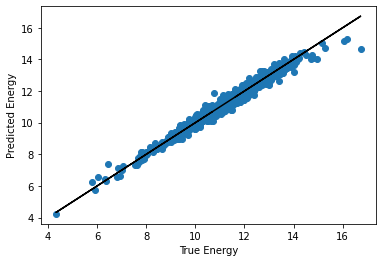

In [68]:
from sklearn.linear_model import Ridge
ln_model = Ridge()
ln_model.fit(train_pred_df,train_target_df)
ln_predictions = ln_model.predict(train_pred_df)
rmse = mean_squared_error(train_target_df, ln_predictions, squared=False)
print('rmse: %.3f' % (rmse))
print('R2 score is: %.3f' % r2_score(train_target_df, ln_predictions))
ln_predictions = ln_model.predict(test_pred_df)
rmse = mean_squared_error(test_target_df, ln_predictions, squared=False)
print('rmse: %.3f' % (rmse))
print('R2 score is: %.3f' % r2_score(test_target_df, ln_predictions))
import matplotlib.pyplot as plt
plt.plot(test_target_df, ln_predictions, 'o')
plt.xlabel('True')
plt.ylabel('Predicted')
# We also plot a diagonal line to show where the prediction should end up.
plt.plot(list(test_target_df),list(test_target_df),'k-') # identity line
plt.show()

rmse: 0.073
R2 score is: 0.997
rmse: 3382244.374
R2 score is: -6646573037331.838


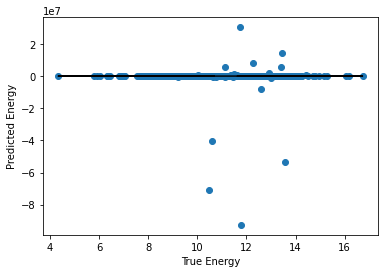

In [69]:
from sklearn.linear_model import LinearRegression
ln_model = LinearRegression()
ln_model.fit(train_pred_df,train_target_df)
ln_predictions = ln_model.predict(train_pred_df)
rmse = mean_squared_error(train_target_df, ln_predictions, squared=False)
print('rmse: %.3f' % (rmse))
print('R2 score is: %.3f' % r2_score(train_target_df, ln_predictions))
ln_predictions = ln_model.predict(test_pred_df)
rmse = mean_squared_error(test_target_df, ln_predictions, squared=False)
print('rmse: %.3f' % (rmse))
print('R2 score is: %.3f' % r2_score(test_target_df, ln_predictions))
import matplotlib.pyplot as plt
plt.plot(test_target_df, ln_predictions, 'o')
plt.xlabel('True')
plt.ylabel('Predicted')
# We also plot a diagonal line to show where the prediction should end up.
plt.plot(list(test_target_df),list(test_target_df),'k-') # identity line
plt.show()

In [ ]:
# homo-lumo

In [76]:
targets_df.columns

Index(['ae_pbe0', 'p_pbe0', 'p_scs', 'homo_gw', 'homo_pbe0', 'homo_zindo',
       'lumo_gw', 'lumo_pbe0', 'lumo_zindo', 'ip_zindo', 'ea_zindo',
       'e1_zindo', 'emax_zindo', 'imax_zindo'],
      dtype='object')

In [77]:
train_pred_df, test_pred_df, train_target_df, test_target_df = train_test_split(df, targets_df['lumo_pbe0']-targets_df['homo_pbe0'], test_size=0.33, random_state=0)

In [78]:
parameters={
    'alpha': np.linspace(1e-11,1,5),
    'gamma': np.linspace(1e-11,1,5),
}
kernel_ridge_tuned = GridSearchCV(
    KernelRidge(kernel='rbf'),
    param_grid=parameters,
    scoring='neg_root_mean_squared_error',
    verbose=2
)
kernel_ridge_tuned.fit(train_pred_df,train_target_df)
kernel_ridge_tuned.best_params_

Fitting 5 folds for each of 25 candidates, totalling 125 fits
[CV] END ...........................alpha=1e-11, gamma=1e-11; total time=   2.0s
[CV] END ...........................alpha=1e-11, gamma=1e-11; total time=   1.5s
[CV] END ...........................alpha=1e-11, gamma=1e-11; total time=   1.3s
[CV] END ...........................alpha=1e-11, gamma=1e-11; total time=   1.3s
[CV] END ...........................alpha=1e-11, gamma=1e-11; total time=   1.2s
[CV] END .................alpha=1e-11, gamma=0.2500000000075; total time=   1.2s
[CV] END .................alpha=1e-11, gamma=0.2500000000075; total time=   1.6s
[CV] END .................alpha=1e-11, gamma=0.2500000000075; total time=   1.1s
[CV] END .................alpha=1e-11, gamma=0.2500000000075; total time=   1.5s
[CV] END .................alpha=1e-11, gamma=0.2500000000075; total time=   1.2s
[CV] END ..................alpha=1e-11, gamma=0.500000000005; total time=   1.4s
[CV] END ..................alpha=1e-11, gamma=0

{'alpha': 1e-11, 'gamma': 1e-11}

In [79]:
parameters={
    'alpha': np.linspace(1e-11,0.1,5),
    'gamma': np.linspace(1e-11,0.1,5),
}
kernel_ridge_tuned = GridSearchCV(
    KernelRidge(kernel='rbf'),
    param_grid=parameters,
    scoring='neg_root_mean_squared_error',
    verbose=2
)
kernel_ridge_tuned.fit(train_pred_df,train_target_df)
kernel_ridge_tuned.best_params_

Fitting 5 folds for each of 25 candidates, totalling 125 fits
[CV] END ...........................alpha=1e-11, gamma=1e-11; total time=   2.1s
[CV] END ...........................alpha=1e-11, gamma=1e-11; total time=   1.5s
[CV] END ...........................alpha=1e-11, gamma=1e-11; total time=   2.0s
[CV] END ...........................alpha=1e-11, gamma=1e-11; total time=   1.4s
[CV] END ...........................alpha=1e-11, gamma=1e-11; total time=   1.3s
[CV] END ............alpha=1e-11, gamma=0.025000000007500002; total time=   5.1s
[CV] END ............alpha=1e-11, gamma=0.025000000007500002; total time=   5.4s
[CV] END ............alpha=1e-11, gamma=0.025000000007500002; total time=   5.1s
[CV] END ............alpha=1e-11, gamma=0.025000000007500002; total time=   5.6s
[CV] END ............alpha=1e-11, gamma=0.025000000007500002; total time=   6.9s
[CV] END ..................alpha=1e-11, gamma=0.050000000005; total time=   3.5s
[CV] END ..................alpha=1e-11, gamma=0

{'alpha': 1e-11, 'gamma': 1e-11}

rmse: 0.34
R2 score is: 0.8109


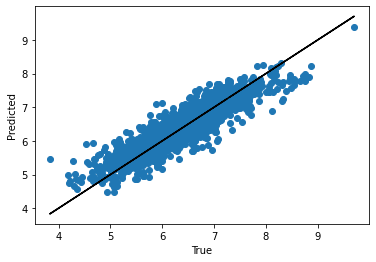

In [80]:
ln_predictions = kernel_ridge_tuned.predict(test_pred_df)
rmse = mean_squared_error(test_target_df, ln_predictions, squared=False)
print('rmse: %.2f' % (rmse))
print('R2 score is: %.4f' % r2_score(test_target_df, ln_predictions))
import matplotlib.pyplot as plt
plt.plot(test_target_df, ln_predictions, 'o')
plt.xlabel('True')
plt.ylabel('Predicted')
# We also plot a diagonal line to show where the prediction should end up.
plt.plot(list(test_target_df),list(test_target_df),'k-') # identity line

In [81]:
parameters={
    'alpha': np.logspace(1e-11,1,5),
    'degree':[1,2,3,4,5]
}
kernel_ridge_tuned = GridSearchCV(
    KernelRidge(kernel='poly'),
    param_grid=parameters,
    scoring='neg_root_mean_squared_error',
    verbose=2
)
kernel_ridge_tuned.fit(train_pred_df,train_target_df)
kernel_ridge_tuned.best_params_

Fitting 5 folds for each of 25 candidates, totalling 125 fits
[CV] END .................alpha=1.0000000000230258, degree=1; total time=   1.6s
[CV] END .................alpha=1.0000000000230258, degree=1; total time=   1.1s
[CV] END .................alpha=1.0000000000230258, degree=1; total time=   1.1s
[CV] END .................alpha=1.0000000000230258, degree=1; total time=   1.1s
[CV] END .................alpha=1.0000000000230258, degree=1; total time=   1.1s
[CV] END .................alpha=1.0000000000230258, degree=2; total time=   1.5s
[CV] END .................alpha=1.0000000000230258, degree=2; total time=   1.1s
[CV] END .................alpha=1.0000000000230258, degree=2; total time=   1.1s
[CV] END .................alpha=1.0000000000230258, degree=2; total time=   1.2s
[CV] END .................alpha=1.0000000000230258, degree=2; total time=   1.7s
[CV] END .................alpha=1.0000000000230258, degree=3; total time=   1.8s
[CV] END .................alpha=1.0000000000230

{'alpha': 1.7782794100696326, 'degree': 3}

rmse: 0.29
R2 score is: 0.8621


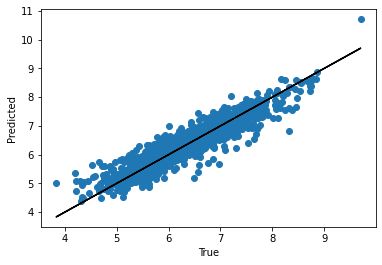

In [82]:
ln_predictions = kernel_ridge_tuned.predict(test_pred_df)
rmse = mean_squared_error(test_target_df, ln_predictions, squared=False)
print('rmse: %.2f' % (rmse))
print('R2 score is: %.4f' % r2_score(test_target_df, ln_predictions))
import matplotlib.pyplot as plt
plt.plot(test_target_df, ln_predictions, 'o')
plt.xlabel('True')
plt.ylabel('Predicted')
# We also plot a diagonal line to show where the prediction should end up.
plt.plot(list(test_target_df),list(test_target_df),'k-') # identity line

In [87]:
kernel_ridge_tuned.best_score_

-6.5431748075256335

Fitting 5 folds for each of 25 candidates, totalling 125 fits
[CV 1/5] END .........alpha=1e-11, gamma=1e-11;, score=-0.355 total time=   2.3s
[CV 2/5] END .........alpha=1e-11, gamma=1e-11;, score=-0.381 total time=   1.7s
[CV 3/5] END .........alpha=1e-11, gamma=1e-11;, score=-0.339 total time=   1.3s
[CV 4/5] END .........alpha=1e-11, gamma=1e-11;, score=-0.350 total time=   1.4s
[CV 5/5] END .........alpha=1e-11, gamma=1e-11;, score=-0.392 total time=   1.3s
[CV 1/5] END alpha=1e-11, gamma=3.1622776601683795e-10;, score=-0.314 total time=   1.3s
[CV 2/5] END alpha=1e-11, gamma=3.1622776601683795e-10;, score=-0.348 total time=   1.6s
[CV 3/5] END alpha=1e-11, gamma=3.1622776601683795e-10;, score=-0.295 total time=   1.0s
[CV 4/5] END alpha=1e-11, gamma=3.1622776601683795e-10;, score=-0.310 total time=   1.3s
[CV 5/5] END alpha=1e-11, gamma=3.1622776601683795e-10;, score=-0.355 total time=   1.3s
[CV 1/5] END .........alpha=1e-11, gamma=1e-08;, score=-0.300 total time=   2.2s
[CV 2/5

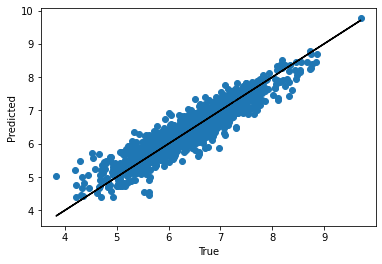

In [92]:
parameters={
    'alpha': np.logspace(-11,-5,5),
    'gamma': np.logspace(-11,-5,5),
}
kernel_ridge_tuned = GridSearchCV(
    KernelRidge(kernel='rbf'),
    param_grid=parameters,
    scoring='neg_root_mean_squared_error',
    verbose=3
)
kernel_ridge_tuned.fit(train_pred_df,train_target_df)
ln_predictions = kernel_ridge_tuned.predict(test_pred_df)
rmse = mean_squared_error(test_target_df, ln_predictions, squared=False)
print('rmse: %.2f' % (rmse))
print('R2 score is: %.4f' % r2_score(test_target_df, ln_predictions))
import matplotlib.pyplot as plt
plt.plot(test_target_df, ln_predictions, 'o')
plt.xlabel('True')
plt.ylabel('Predicted')
# We also plot a diagonal line to show where the prediction should end up.
plt.plot(list(test_target_df),list(test_target_df),'k-') # identity line

In [91]:
kernel_ridge_tuned.best_params_

{'alpha': 3.1622776601683795e-10, 'gamma': 1e-08}